# Einlesen der Daten

Dieser Code liest den Datensatz ein, normalisiert die Produktspalten, entfernt Zeilen mit NaN-Werten in der Spalte 'Product Name' und schließlich die Spalte 'Product Column'.

In [1]:
#!pip3 install requirements.txt -r

In [2]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
import pandas as pd

In [4]:
# Einlesen des CSV-Datensatzes
df_raw = pd.read_csv('bauerntuete.csv', sep=';', encoding='latin1')

# Normalisieren der Produkt Spalten
product_columns = [f'Produkt Name #{i}' for i in range(1, 9)]
id_vars = ['Bestell ID', 'Shipping Postcode', 'Shipping City', 'Customer ID']
df = df_raw.melt(
    id_vars=id_vars,
    value_vars=product_columns, 
    var_name='Product Column', 
    value_name='Product Name'
)

# Entfernen von Zeilen mit NaN Einträgen in der 'Product Name' Spalte
df = df.dropna(subset=['Product Name'])

# Entfernen der 'Product Column' Spalte
df = df.drop(columns=['Product Column'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1816 entries, 0 to 10936
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Bestell ID         1816 non-null   int64 
 1   Shipping Postcode  1816 non-null   int64 
 2   Shipping City      1816 non-null   object
 3   Customer ID        1816 non-null   int64 
 4   Product Name       1816 non-null   object
dtypes: int64(3), object(2)
memory usage: 85.1+ KB


In [6]:
# Ausgabe des normalisierten DataFrame
df.head()

,Bestell ID,Shipping Postcode,Shipping City,Customer ID,Product Name
0,42533,50935,Köln,1,Bio Gemüsekiste(ca. 5Kg)
1,41483,50935,Köln,1,Bio Obst &amp; Gemüse (ca. 5 kg)
2,41591,51103,Köln,2,"Bauerntüte ""klassik"""
3,40070,50677,Köln,3,Bio Obst &amp; Gemüse (ca. 5 kg)
4,35409,50933,Köln,3,"Bauerntüte ""klassik"""


# Datenexpl

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

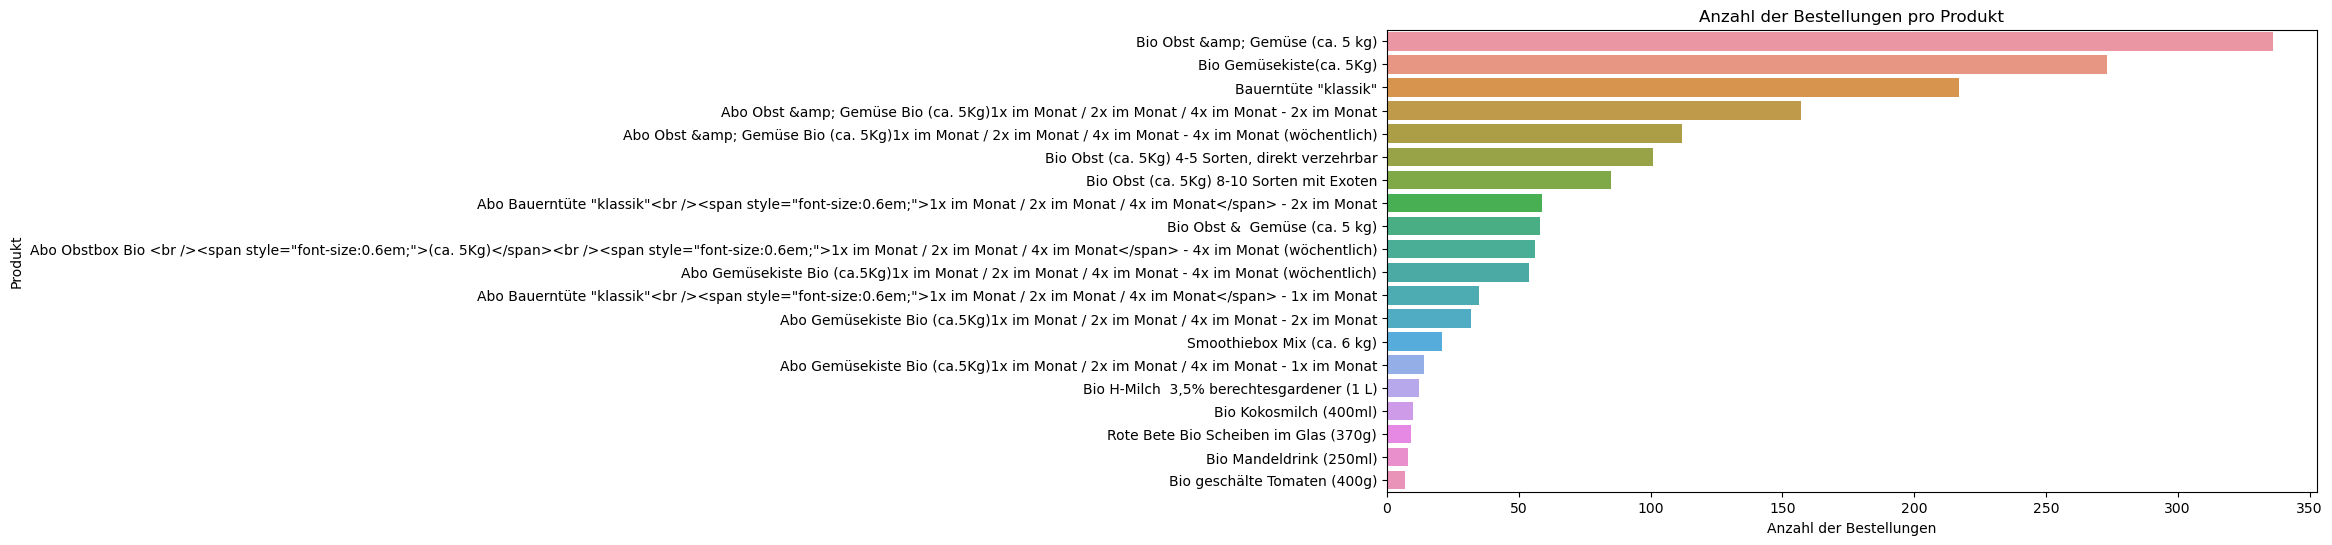

In [8]:
# Anzahl der Bestellungen pro Produkt visualisieren für Top N Produkte
top_n = 20
plt.figure(figsize=(12, 6))
sns.countplot(y='Product Name', data=df, order=df['Product Name'].value_counts().head(top_n).index)
plt.title('Anzahl der Bestellungen pro Produkt')
plt.xlabel('Anzahl der Bestellungen')
plt.ylabel('Produkt')
plt.show()

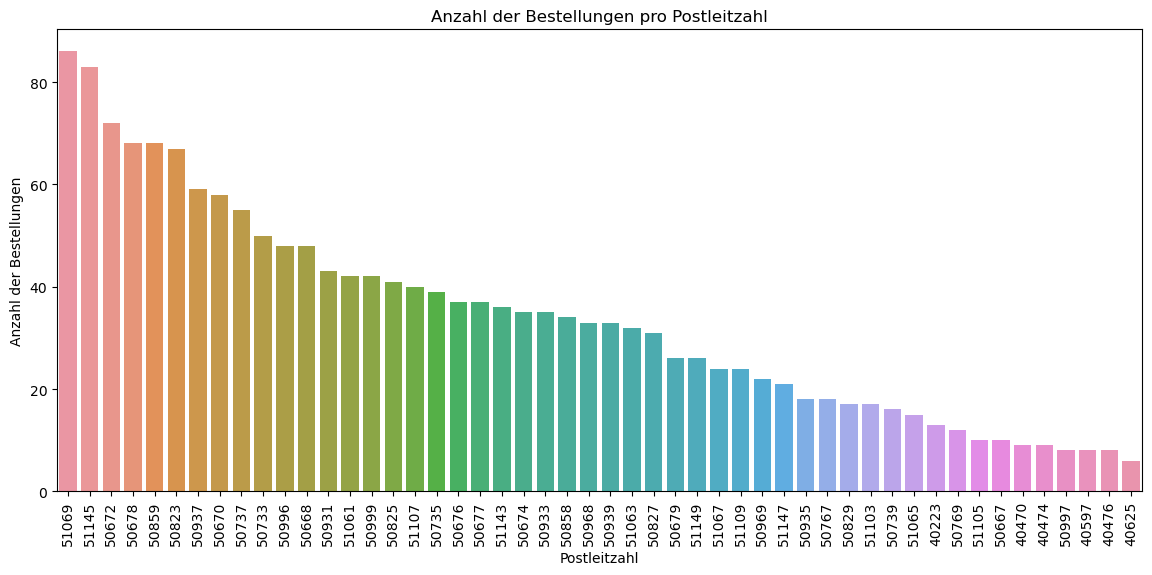

In [9]:
# Anzahl der Bestellungen pro Postleitzahl visualisieren
top_n = 50
plt.figure(figsize=(14, 6))
sns.countplot(x='Shipping Postcode', data=df, order=df['Shipping Postcode'].value_counts().head(top_n).index)
plt.title('Anzahl der Bestellungen pro Postleitzahl')
plt.xlabel('Postleitzahl')
plt.ylabel('Anzahl der Bestellungen')
plt.xticks(rotation=90)
plt.show()

In [10]:
# Bestellungen pro Stadt
df['Shipping City'].unique()

array(['Köln', 'DUESSELDORF', 'Düsseldorf', 'Köln, Ehrenfeld',
       'Köln porz eil', 'dusseldorf', 'köln', 'Koeln', 'Duesseldorf',
       'DÜSSELDORF', 'Leverkusen', 'Gelsenkirchen', 'Köln-Rodenkirchen',
       'Köln - Rodenkirchen', 'Dorsten', 'Jülich', 'Koln', 'Erfstadt',
       'Düren- Gürzenich', 'Münster', 'koeln', 'KÖLN', 'Köln-Ehrenfeld',
       'Köln Rodenkirchen', 'Neukirchen-Vluyn', 'Hagen-Hohenlimburg',
       'Köln, Deutschland', 'Aachen', 'Trier', 'Köln Altstadt-Süd',
       'düsseldorf', 'Bergisch Gladbach'], dtype=object)

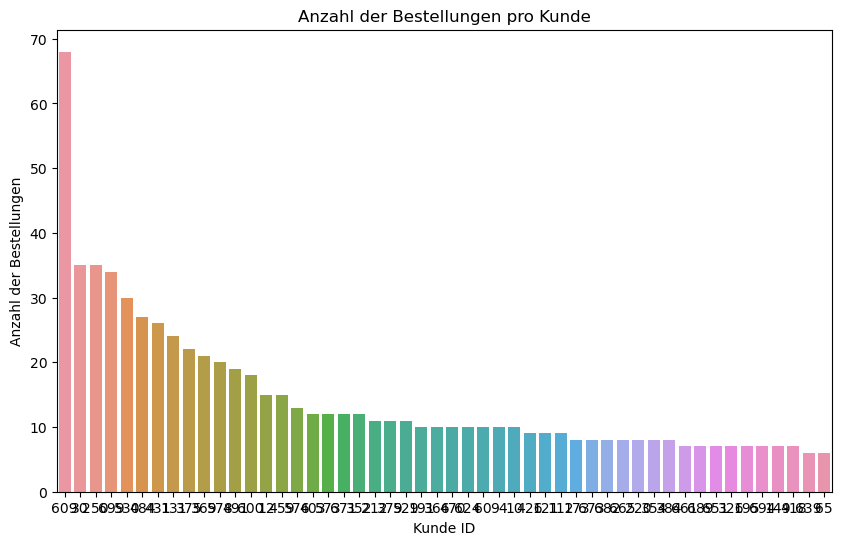

In [11]:
# Anzahl der Bestellungen pro Kunde visualisieren
top_n = 50
plt.figure(figsize=(10, 6))
sns.countplot(x='Customer ID', data=df, order=df['Customer ID'].value_counts().head(top_n).index)
plt.title('Anzahl der Bestellungen pro Kunde')
plt.xlabel('Kunde ID')
plt.ylabel('Anzahl der Bestellungen')
plt.show()

In [12]:
import folium
import json

# Laden der Koordinaten aus der JSON-Datei
with open('postcode_coordinates.json', 'r') as f:
    postcode_coords = json.load(f)['postcode_coords']

def get_coords(postcode):
    """Funktion zur Zuordnung von Postleitzahlen zu Koordinaten."""
    return postcode_coords.get(str(postcode), (None, None))

# Einlesen des CSV-Datensatzes
df_raw = pd.read_csv('bauerntuete.csv', sep=';', encoding='latin1')

# Normalisieren der Produkt Spalten
product_columns = [f'Produkt Name #{i}' for i in range(1, 9)]
id_vars = ['Bestell ID', 'Shipping Postcode', 'Shipping City', 'Customer ID']
df = df_raw.melt(
    id_vars=id_vars,
    value_vars=product_columns, 
    var_name='Product Column', 
    value_name='Product Name'
)

# Entfernen von Zeilen mit NaN Einträgen in der 'Product Name' Spalte
df = df.dropna(subset=['Product Name'])

# Entfernen der 'Product Column' Spalte
df = df.drop(columns=['Product Column'])

# Hinzufügen von Koordinaten auf Basis der Postleitzahlen
df['Coords'] = df['Shipping Postcode'].apply(get_coords)
df[['Latitude', 'Longitude']] = pd.DataFrame(df['Coords'].tolist(), index=df.index)

# Entfernen von Einträgen ohne Koordinaten
df = df.dropna(subset=['Latitude', 'Longitude'])

# Erstellen der Karte
m = folium.Map(location=[51.1657, 10.4515], zoom_start=6)  # Zentrum von Deutschland

# Hinzufügen der Markierungen
for idx, row in df.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']],
                  popup=f"Postcode: {row['Shipping Postcode']}, Product: {row['Product Name']}").add_to(m)

# Speichern der Karte in einer HTML-Datei
m.save('postcode_map.html')

print("Die Karte wurde gespeichert und kann in einem Webbrowser angezeigt werden.")

Die Karte wurde gespeichert und kann in einem Webbrowser angezeigt werden.


In [13]:
m

# Zwischenfazit

## Chancen der daten-getriebenen und KI-gestützten Arbeit für den Online Händler

1. **Personalisierte Marketingstrategien und Empfehlungen:**
   - Durch die Analyse von Kaufmustern und Präferenzen der Kunden kann der Händler personalisierte Produktempfehlungen und gezielte Marketingkampagnen entwickeln. Dies kann zu einer höheren Kundenzufriedenheit und gesteigerten Verkaufszahlen führen.
   - Machine Learning-Algorithmen können verwendet werden, um Kunden in verschiedene Segmente zu unterteilen und deren zukünftige Kaufentscheidungen vorherzusagen. Dadurch können maßgeschneiderte Angebote und Rabatte erstellt werden, die die Kundenbindung erhöhen.

2. **Optimierung des Lagerbestands und der Lieferkette:**
   - Durch die Analyse der Bestelldaten kann der Händler besser prognostizieren, welche Produkte zu bestimmten Zeiten am gefragtesten sind und somit die Lagerbestände entsprechend anpassen. Dies reduziert Lagerkosten und verhindert Engpässe.
   - KI-gestützte Systeme können helfen, die Effizienz der Lieferkette zu verbessern, indem sie optimale Routen und Lieferzeiten berechnen, was zu Kosteneinsparungen und einer schnelleren Lieferung führt.

## Limitationen der Daten und Empfehlungen für eine dedizierte Datenstrategie

1. **Unvollständige Daten und fehlende Datentiefe:**
   - Die vorhandenen Daten umfassen hauptsächlich Bestellinformationen und grundlegende Kundendaten. Es fehlen detaillierte Informationen über das Kundenverhalten auf der Website, wie z.B. Browsing-Historie, Klickpfade und Verweildauer.
   - **Empfehlung:** Implementierung von Tracking-Mechanismen auf der Website, um umfassendere Daten über das Kundenverhalten zu sammeln. Dies kann durch Web-Analytics-Tools und Event-Tracking erfolgen.

2. **Datenqualität und Konsistenz:**
   - Die Daten weisen möglicherweise Inkonsistenzen und fehlende Werte auf, die die Analyse und die darauf basierenden Entscheidungen beeinträchtigen können.
   - **Empfehlung:** Entwicklung einer robusten Datenqualitätsstrategie, die regelmäßige Datenbereinigung, Validierung und Standardisierung einschließt. Die Einführung automatisierter Datenintegritätsprüfungen kann helfen, die Datenqualität zu gewährleisten.

Durch die Beachtung dieser Chancen und Limitationen kann der Online Händler eine fundierte Datenstrategie entwickeln, die langfristig mehr Geschäftswert aus den vorhandenen Daten schöpft und die Basis für datengetriebene und KI-gestützte Entscheidungsprozesse bildet.

# Kurz-Demo: Produktvorschläge generieren

Um Produktvorschläge zu erstellen, die auf einem bestimmten Produkt basieren und anzeigen, welche anderen Produkte von Kunden, die das gleiche Produkt gekauft haben, ebenfalls gekauft wurden, können wir die Assoziationsregel-Mining-Technik verwenden. 

### Erklärung:

1. **Datenvorbereitung:**
   - Der Datensatz wird eingelesen und normalisiert, um eine Liste von Bestellungen mit den entsprechenden Produkten zu erstellen.
   - Die Daten werden so umorganisiert, dass jede Bestellung eine Zeile ist und jede Spalte ein Produkt. Der Wert ist 1, wenn das Produkt in der Bestellung enthalten ist, und 0, wenn nicht.

2. **Assoziationsregeln berechnen:**
   - Wir verwenden die `apriori`-Funktion, um häufig zusammen gekaufte Produkte zu identifizieren.
   - Die `association_rules`-Funktion berechnet die Assoziationsregeln basierend auf diesen häufigen Itemsets.

3. **Empfehlungen generieren:**
   - Die Funktion `generate_recommendations` nimmt ein Produkt und die berechneten Regeln als Eingabe und gibt eine Liste von empfohlenen Produkten zurück.
   - Die Empfehlungen basieren auf den Produkten, die häufig zusammen mit dem ausgewählten Produkt gekauft wurden.

Dieser Code kann in die Backend-Logik einer E-Commerce-Website integriert werden, um Produktvorschläge auf den Produktseiten anzuzeigen.

In [14]:
# Schritt 1: Daten vorbereiten
basket = df.groupby(['Bestell ID', 'Product Name']).size().unstack().reset_index().fillna(0).set_index('Bestell ID')
basket = basket.map(lambda x: 1 if x > 0 else 0)

In [15]:
# Schritt 2: Assoziationsregeln berechnen
from mlxtend.frequent_patterns import apriori, association_rules
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

C:\Users\seckstedt\AppData\Local\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [16]:
# Schritt 3: Empfehlungen generieren
def generate_recommendations(product_name, rules, top_n=5):
    recommendations = rules[rules['antecedents'].apply(lambda x: product_name in x)]
    recommendations = recommendations.sort_values(by='lift', ascending=False)
    recommended_products = []
    for _, row in recommendations.iterrows():
        for item in row['consequents']:
            if item != product_name and item not in recommended_products:
                recommended_products.append(item)
    return recommended_products[:top_n]

In [17]:
# Code zur Integration der Empfehlungen in die Produktseite
def display_recommendations(product_name):
    recommended_products = generate_recommendations(product_name, rules)
    print(f"Empfohlene Produkte für '{product_name}':")
    for product in recommended_products:
        print(f"- {product}")

In [18]:
# Beispiel: Empfehlungen für ein bestimmtes Produkt anzeigen
display_recommendations("Bio Gemüsekiste(ca. 5Kg)")

Empfohlene Produkte für 'Bio Gemüsekiste(ca. 5Kg)':
- Bio Obst (ca. 5Kg) 8-10 Sorten mit Exoten
- Bio Obst (ca. 5Kg) 4-5 Sorten, direkt verzehrbar


# Kurz-Demo: Kunden Clustering

Um Kunden anhand ihres Kaufverhaltens zu clustern, verwenden wir ein Clustering-Verfahren wie K-Means.

### Erklärung:

1. **Datenaufbereitung**:
   - Wir lesen den Datensatz ein und normalisieren die Produktspalten.
   - Wir aggregieren die Daten auf Kundenebene, sodass jede Zeile einen Kunden darstellt und jede Spalte ein Produkt. Der Wert in der Zelle ist die Anzahl der Bestellungen des Produkts durch den Kunden.
   - Die Daten werden normalisiert, um Verzerrungen durch unterschiedlich aktive Kunden zu vermeiden.

2. **Clustering**:
   - Wir verwenden die Elbow-Methode, um die optimale Anzahl von Clustern zu finden.
   - Wir führen das Clustering mit K-Means durch und weisen jedem Kunden einen Cluster zu.

3. **Interpretation**:
   - Wir analysieren die Cluster-Zentroiden, um die charakteristischen Kaufmuster jedes Clusters zu verstehen.
   - Wir visualisieren die Cluster und interpretieren sie qualitativ, indem wir die häufigsten Produkte in jedem Cluster anzeigen.

In [19]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# Schritt 1: Datenaufbereitung
# Aggregieren der Daten auf Kundenebene
customer_product_df = df.groupby(['Customer ID', 'Product Name']).size().unstack().fillna(0)

# Normalisieren der Daten
customer_product_df_normalized = customer_product_df.div(customer_product_df.sum(axis=1), axis=0)

C:\Users\seckstedt\AppData\Local\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\seckstedt\AppData\Local\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\seckstedt\AppData\Local\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\seckstedt\AppData\Local\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will

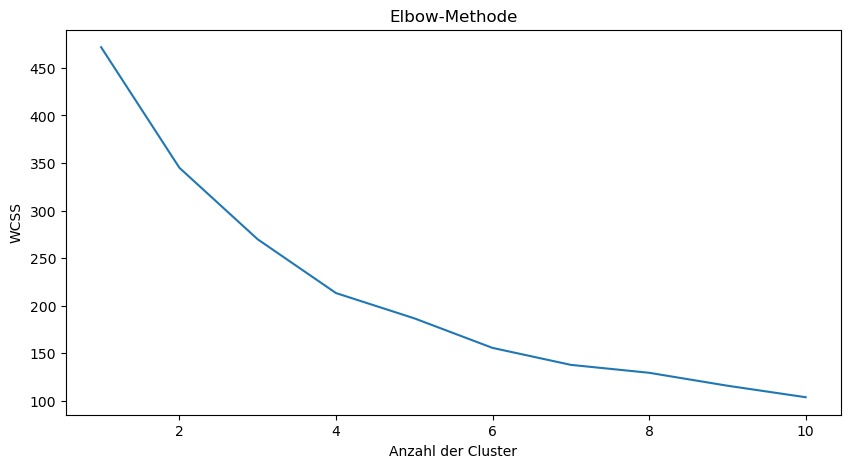

C:\Users\seckstedt\AppData\Local\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\seckstedt\AppData\Local\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\seckstedt\AppData\Local\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\seckstedt\AppData\Local\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will

In [21]:
# Schritt 2: Clustering
# Finden der optimalen Anzahl von Clustern mittels Elbow-Methode
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(customer_product_df_normalized)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss)
plt.title('Elbow-Methode')
plt.xlabel('Anzahl der Cluster')
plt.ylabel('WCSS')
plt.show()

# Auswahl der Anzahl der Cluster (z.B. 3)
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
customer_product_df['Cluster'] = kmeans.fit_predict(customer_product_df_normalized)

C:\Users\seckstedt\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\seckstedt\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\seckstedt\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


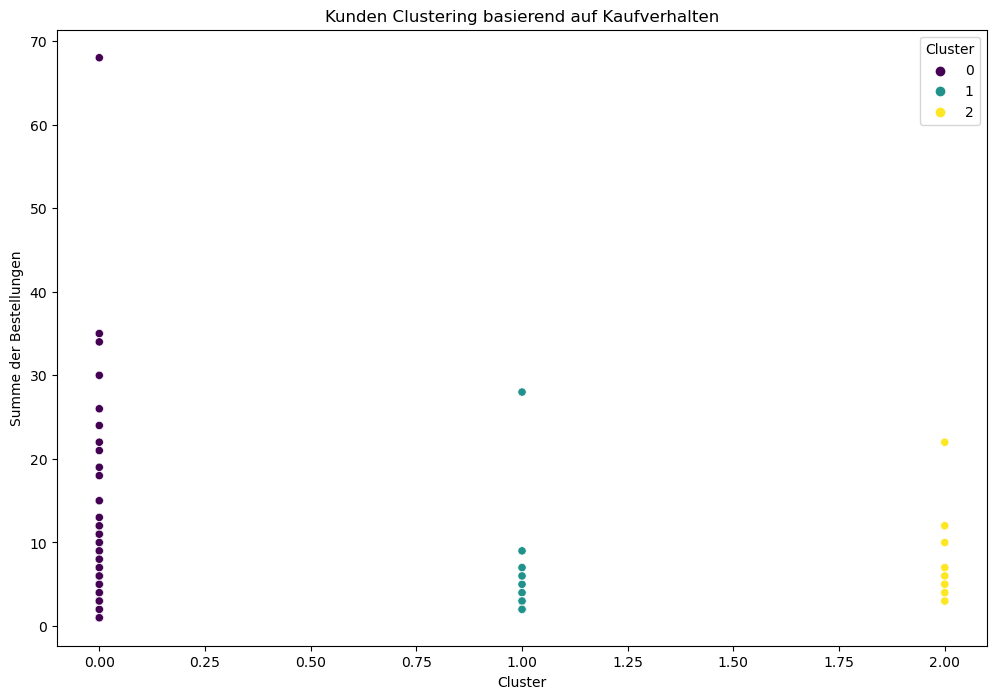

In [22]:
# Schritt 3: Interpretation der Cluster
# Cluster-Zentroiden anzeigen
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=customer_product_df.columns[:-1])

# Visualisierung der Cluster
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Cluster', y=customer_product_df.sum(axis=1), hue='Cluster', data=customer_product_df, palette='viridis')
plt.title('Kunden Clustering basierend auf Kaufverhalten')
plt.xlabel('Cluster')
plt.ylabel('Summe der Bestellungen')
plt.show()

In [23]:
# Qualitative Interpretation der Cluster
for cluster_num in range(optimal_clusters):
    cluster_data = customer_product_df[customer_product_df['Cluster'] == cluster_num]
    print(f"\nCluster {cluster_num} - Anzahl der Kunden: {len(cluster_data)}")
    print(cluster_data.sum(numeric_only=True).sort_values(ascending=False).head(10))


Cluster 0 - Anzahl der Kunden: 412
Product Name
Bio Gemüsekiste(ca. 5Kg)                                                                                                                                                                269.0
Abo Obst &amp; Gemüse Bio (ca. 5Kg)1x im Monat / 2x im Monat / 4x im Monat - 2x im Monat                                                                                                153.0
Abo Obst &amp; Gemüse Bio (ca. 5Kg)1x im Monat / 2x im Monat / 4x im Monat - 4x im Monat (wöchentlich)                                                                                  109.0
Bio Obst (ca. 5Kg) 4-5 Sorten, direkt verzehrbar                                                                                                                                         95.0
Bio Obst (ca. 5Kg) 8-10 Sorten mit Exoten                                                                                                                                                79.0
B

## Interpretation der Cluster aus Sicht des Marketings

### Zusammenfassung
Durch die Cluster-Analyse können wir drei Hauptkundengruppen identifizieren:
1. **Cluster 0**: Abonnement-Nutzer mit einer Vorliebe für vielfältige Obst- und Gemüsekisten.
2. **Cluster 1**: Kunden, die stark auf ein einzelnes Produkt fokussiert sind, insbesondere die Bauerntüte "klassik".
3. **Cluster 2**: Häufige Käufer von Bio Obst & Gemüse, mit einem moderaten Interesse an Abonnement-Produkten.

#### Cluster 0 - Anzahl der Kunden: 412
**Hauptprodukte:**
- Bio Gemüsekiste(ca. 5Kg)
- Abo Obst & Gemüse Bio (ca. 5Kg) - 2x im Monat
- Abo Obst & Gemüse Bio (ca. 5Kg) - 4x im Monat (wöchentlich)
- Bio Obst (ca. 5Kg) 4-5 Sorten, direkt verzehrbar
- Bio Obst (ca. 5Kg) 8-10 Sorten mit Exoten

**Marketing-Interpretation:**
- **Abonnement-Nutzer:** Diese Kunden sind stark an Abonnement-Produkten interessiert, insbesondere an Obst- und Gemüsekisten, die regelmäßig geliefert werden. 
- **Vielfältige Produktpräferenzen:** Kunden in diesem Cluster kaufen eine Vielzahl von Obst- und Gemüsesorten, was auf eine gesundheitsbewusste und abwechslungsreiche Ernährung hindeutet.
- **Treue Kunden:** Die hohe Anzahl an Abonnement-Käufen könnte auf eine treue Kundengruppe hinweisen, die regelmäßig bei dem Online-Händler einkauft.

**Marketing-Strategien:**
- **Gezielte Abonnement-Angebote:** Entwickeln Sie spezielle Abonnement-Angebote oder Rabatte für diese Kunden, um die Bindung zu stärken.
- **Cross-Selling:** Bewerben Sie andere gesunde Lebensmittel und neue Produkte, die zu ihrem bestehenden Warenkorb passen.
- **Personalisierte Kommunikation:** Nutzen Sie personalisierte E-Mails und Benachrichtigungen, um diese Kunden über neue Abonnement-Optionen und Sonderangebote zu informieren.

#### Cluster 1 - Anzahl der Kunden: 111
**Hauptprodukte:**
- Bauerntüte "klassik"
- Bio Obst & Gemüse (ca. 5 kg)
- Bio Obst (ca. 5Kg) 8-10 Sorten mit Exoten

**Marketing-Interpretation:**
- **Einzelprodukt-Käufer:** Diese Kunden haben eine starke Präferenz für ein bestimmtes Produkt, die Bauerntüte "klassik".
- **Weniger Abwechslung:** Im Vergleich zu Cluster 0 kaufen diese Kunden weniger verschiedene Produkte, was auf eine spezifischere Nachfrage hinweisen könnte.

**Marketing-Strategien:**
- **Produkt-Bundles:** Entwickeln Sie Produkt-Bundles, die die Bauerntüte "klassik" mit anderen Produkten kombiniert, um den Warenkorbwert zu erhöhen.
- **Spezialisierte Angebote:** Erstellen Sie spezielle Angebote und Rabatte für die Bauerntüte "klassik", um diese Kunden weiter zu binden.
- **Kundenfeedback einholen:** Sammeln Sie Feedback von diesen Kunden, um zu verstehen, warum sie sich auf bestimmte Produkte konzentrieren, und nutzen Sie diese Informationen, um das Produktsortiment zu verbessern.

#### Cluster 2 - Anzahl der Kunden: 188
**Hauptprodukte:**
- Bio Obst & Gemüse (ca. 5 kg)
- Bauerntüte "klassik"

**Marketing-Interpretation:**
- **Häufige Käufer:** Diese Kunden scheinen häufig die Bio Obst & Gemüse (ca. 5 kg) zu kaufen, was darauf hindeutet, dass sie regelmäßige Käufer sind.
- **Abonnement-Interesse:** Es gibt auch Interesse an Abonnement-Produkten, jedoch in geringerem Maße als in Cluster 0.

**Marketing-Strategien:**
- **Treueprogramme:** Implementieren Sie Treueprogramme, um diese häufigen Käufer zu belohnen und ihre Bindung zu stärken.
- **Erweiterung der Abonnements:** Fördern Sie Abonnement-Optionen, um diese Kunden zu regelmäßigen Abonnenten zu machen.
- **Produktvielfalt:** Bewerben Sie eine breite Palette von Produkten, um diese Kunden dazu zu ermutigen, neue Artikel auszuprobieren und ihren Warenkorb zu diversifizieren.